### Welcome to the Datacation Bootcamp!

Today, we present a coding challenge to you.
In this challenge, you will be given two brain tumor dataset. A train and a test dataset.
The target variable has been removed from the test dataset. You will try different Machine Learning models and
use your best model to predict whether patients have a brain tumor or not.

Try to get as far as possible in the following exercises, increasing in difficulty:

1. Loading the training set train_brain.csv and split the training set in a training and validation set, then preprocess the data. Options include:
    - imputing missing values
    - one-hot-encoding categorical values
    - scaling the data
2. Implement the machine learning model called the Support Vector Machine (SVM) and optimize based on the validation accuracy.
3. Visualize the SVM accuracy results in a graph.
4. Use a grid search to find the optimal hyperparameters of the SVM, KNN and RandomForest models using 3-fold cross validation.
5. Visualize the SVM, KNN and RandomForest accuracy results in a heatmap.
6. Implement a Neural Network and visualize the loss and accuracy, both for the test and training dataset.
7. Apply any type of model and preprocessing steps necessary to achieve the highest possible validation accuracy.
8. Use the test_brain.csv dataset to predict whether the patients have a brain tumor or not. The target variable has been removed from the dataset.
   Save the prediction results in a list with the same order as the patients in the test dataset.
   Use the given code to store the list as .pkl file and save it using your group number.
   Finally, do a push request to the github repository. We will calculate your final accuracy score.


In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import TargetEncoder
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
######################################   EXERCISE 1   ######################################
'''
Loading the training set train_brain.csv and split the training set in a training and validation set, then preprocess the data. Options include:
    - imputing missing values
    - one-hot-encoding categorical values
    - scaling the data
'''
# Read in the dataset: (https://pandas.pydata.org/docs/reference/api/pandas.read_csv.html)
train_data = pd.read_csv('train_brain.csv')
data_columns = train_data.columns

# Split the training set in a train and validation set, use random_state = 0: (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
y = train_data['target'].to_numpy()
X = train_data[[column for column in data_columns if column != 'target']]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.33, random_state=0)

# The list of the names of all categorical and numerical features
categorical = X.select_dtypes(include=["O"]).columns.tolist()
numerical = X.select_dtypes(exclude=["O"]).columns.tolist()

# # Impute missing values: (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
## Impute missing numerical values
imp_num = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_numeric = imp_num.fit_transform(X_train[numerical])
X_val_numeric = imp_num.transform(X_val[numerical])

## Impute missing categorical values
imp_cat = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
X_train_categorical = imp_cat.fit_transform(X_train[categorical])
X_val_categorical = imp_cat.transform(X_val[categorical])

# # One hot encode categorical values
# onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
# X_train_categorical = onehot.fit_transform(X_train_categorical)
# X_train_categorical = onehot.fit_transform(X_train_categorical)

# Target encode categorical values
target_enc = TargetEncoder()
X_train_categorical = target_enc.fit_transform(X_train_categorical, y_train)
X_val_categorical = target_enc.transform(X_val_categorical, y_val)

# Scale numerical columns: (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
standard_scaler = StandardScaler()
X_train_numeric = standard_scaler.fit_transform(X_train_numeric)
X_val_numeric = standard_scaler.transform(X_val_numeric)

# Rejoin two numpy arrays to create a single dataset
X_train = np.concatenate((X_train_numeric, X_train_categorical), axis=1)
X_val = np.concatenate((X_val_numeric, X_val_categorical), axis=1)

c:\users\20191685\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [13]:
X_train_s, _, y_train_s, _ = train_test_split(X_train, y_train, test_size=0.9, stratify=y_train, random_state=0)

In [5]:
######################################   EXERCISE 2   ######################################
'''
Implement the machine learning model called the Support Vector Machine (SVM) and optimize based on the validation accuracy.
'''

# Implement the Support Vector Machine: (https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
def evaluate_SVM(X_train, y_train, X_val, y_val, C, gamma):
    """ evaluate the SVM model with different hyper-parameter settings """
    # Create SVM model and train on train data
    svc = SVC(gamma=gamma, C=C).fit(X_train, y_train)
    
    # Predict labels of validation data
    y_pred = svc.predict(X_val)
    
    # Return accuracy of prediction
    return accuracy_score(y_true=y_val, y_pred=y_pred)

# evaluate_SVM(X_train=X_train_s,
#              y_train=y_train_s,
#              X_val=X_val,
#              y_val=y_val,
#              C=1.0,
#              gamma="scale")

In [9]:
######################################   EXERCISE 3   ######################################
'''
Visualize the SVM accuracy results in a graph.
'''

# Visualize the SVM results: (https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.html)
# First optimize C value
C_range = np.logspace(-5, 5, num=10)
C_values = []
accuracies_C = []
for c in tqdm(C_range):
    C_values.append(c)
    accuracies_C.append(evaluate_SVM(X_train=X_train_s,
                                     y_train=y_train_s,
                                     X_val=X_val,
                                     y_val=y_val,
                                     C=c,
                                     gamma="scale"))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:26<00:00,  8.69s/it]


In [14]:
# Retrieve optimal C value
optimal_C = C_values[np.argmax(np.array(accuracies_C))]

gamma_range = np.logspace(-5, 5, num=10)
gamma_values = []
accuracies_gamma = []
for g in tqdm(gamma_range):
    gamma_values.append(g)
    accuracies_gamma.append(evaluate_SVM(X_train=X_train_s,
                                     y_train=y_train_s,
                                     X_val=X_val,
                                     y_val=y_val,
                                     C=optimal_C,
                                     gamma=g))

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:37<00:00,  3.76s/it]


In [18]:
# Retrieve optimal gamma value
optimal_gamma = gamma_values[np.argmax(np.array(accuracies_gamma))]

# Print optimal settings
print(f'Optimal setting: C = {optimal_C}, gamma = {optimal_gamma}')

Optimal setting: C = 1e-05, gamma = 1e-05


In [10]:
def simple_pipeline(X, clf):
    # Pipeline for categorical features
    cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'), TargetEncoder())
    # Pipeline for numerical features
    num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
    # Column transformer for both types of features. We use 'remainder' for the numerical ones.
    categorical = X.select_dtypes(include=["O"]).columns.tolist()
    transform = make_column_transformer((cat_pipe, categorical), remainder=num_pipe)
    
    return make_pipeline(transform, clf)

def heatmap(columns, rows, scores, xlabel=None, ylabel=None):
    """ Plot Heatmap of the obtained accuracy scores """
    df = pd.DataFrame(scores, index=rows, columns=columns)
    sns.heatmap(df, cmap='Greens', linewidths=0.5, annot=True, fmt=".3f")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

In [ ]:
######################################   EXERCISE 4   ######################################
'''
Use a grid search to find the optimal hyperparameters of the SVM, KNN and RandomForest models using 3-fold cross validation.
'''

# Make use of GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# RandomForest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Get subset of complete dataset
Xs, _, ys, _ = train_test_split(X, y, test_size=0.99, stratify=y)

# Set param grid
param_grid = {'svc__C': [0.1, 1, 10, 100, 1000],
              'svc__gamma': [0.0001, 0.001, 0.01, 0.1, 1]}

# Create simple pipeline
pipeline = simple_pipeline(X=Xs, clf=SVC())
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cvs, n_jobs=-1, scoring='roc_auc').fit(X,y)

scores = grid.cv_results_['mean_test_score'].reshape(5, -1)
    
heatmap(param_grid['svc__C'], param_grid['svc__gamma'], scores, 'C','gamma')


c:\users\20191685\appdata\local\programs\python\python38\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


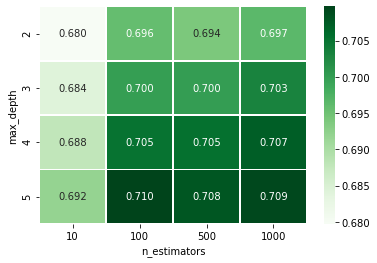

In [4]:
######################################   EXERCISE 4   ######################################
'''
Use a grid search to find the optimal hyperparameters of the SVM, KNN and RandomForest models using 3-fold cross validation.
'''

# Make use of GridSearchCV: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
# KNN: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
# RandomForest: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

# Get subset of complete dataset
Xs, _, ys, _ = train_test_split(X, y, test_size=0.99, stratify=y)

# Set param grid
param_grid = {'randomforestclassifier__n_estimators': [10, 100, 500, 1000],
              'randomforestclassifier__max_depth': [2, 3, 4, 5]}

# Create simple pipeline
pipeline = simple_pipeline(X=Xs, clf=RandomForestClassifier())
cvs = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
grid = GridSearchCV(pipeline, param_grid=param_grid, cv=cvs, n_jobs=-1, scoring='roc_auc').fit(X,y)

scores = grid.cv_results_['mean_test_score'].reshape(4, -1)
    
heatmap(param_grid['randomforestclassifier__n_estimators'], param_grid['randomforestclassifier__max_depth'], scores, 'n_estimators','max_depth')

In [ ]:
######################################   EXERCISE 5   ######################################
'''
Visualize the SVM, KNN and RandomForest accuracy results in a heatmap.
'''

# Make us of a heatmap: https://seaborn.pydata.org/generated/seaborn.heatmap.html



In [6]:
######################################   EXERCISE 6   ######################################
'''
Implement a basic Neural Network and visualize the loss and accuracy, both for the test and training dataset.
'''

from sklearn.neural_network import MLPClassifier

X_train_s, _, y_train_s, _ = train_test_split(X_train, y_train, test_size=0.9, stratify=y_train, random_state=0)

# Make use of the MLPClassifier: https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier
clf = MLPClassifier(random_state=0, max_iter=300, hidden_layer_sizes=256).fit(X_train_s, y_train_s)

y_pred = clf.predict(X_val)

score = accuracy_score(y_true=y_val, y_pred=y_pred)

print(score)


0.7185250109559882


In [16]:
test_data = pd.read_csv('test_brain.csv')

In [19]:
# The list of the names of all categorical and numerical features
categorical = test_data.select_dtypes(include=["O"]).columns.tolist()
numerical = test_data.select_dtypes(exclude=["O"]).columns.tolist()

# # Impute missing values: (https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
## Impute missing numerical values
X_num = imp_num.transform(test_data[numerical])

## Impute missing categorical values
X_cat = imp_cat.transform(test_data[categorical])

# # One hot encode categorical values
# onehot = OneHotEncoder(sparse=False, handle_unknown='ignore')
# X_train_categorical = onehot.fit_transform(X_train_categorical)
# X_train_categorical = onehot.fit_transform(X_train_categorical)

# Target encode categorical values
X_cat = target_enc.transform(X_cat)

# Scale numerical columns: (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
X_num = standard_scaler.transform(X_num)

# Rejoin two numpy arrays to create a single dataset
X = np.concatenate((X_num, X_cat), axis=1)

In [28]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline

def sample_pipeline(ros, rus):
    """ Return pipeline for up- and downsampling of the training data """
    return imb_Pipeline(steps=[('o', ros), ('u', rus)])

rand_oversampler = RandomOverSampler(sampling_strategy=0.6, random_state=0)
rand_undersampler = RandomUnderSampler(sampling_strategy=0.8, random_state=0)

# Create pipeline
sample = sample_pipeline(ros=rand_oversampler, rus=rand_undersampler)

In [29]:
X_train_s, y_train_s = sample.fit_resample(X_train_s, y_train_s)

In [36]:
######################################   EXERCISE 7   ######################################
'''
Apply any type of model and preprocessing steps necessary to achieve the highest possible validation accuracy.
'''

# svc = SVC(gamma=1e-5, C=1e-5).fit(X_train_s, y_train_s)
rf = RandomForestClassifier(n_estimators=100, max_depth=4).fit(X_train_s, y_train_s)


In [37]:
y_pred = rf.predict(X)

In [42]:
######################################   EXERCISE 8   ######################################
'''
Time to predict using your best ML model!
Use the test_brain.csv dataset to predict whether the patients have a brain tumor or not. The target variable has been removed from the dataset.
Save the prediction results in a list with the same order as the patients in the test dataset.
Use the below given code to store the list as .pkl file and save it using your group number.
Finally, do a push request to the github repository. We will calculate your final accuracy score.
'''

import pickle

group_number = 5
ypred = y_pred

with open(f'test_predictions_group_{group_number}.pkl', 'wb') as f:
    pickle.dump(ypred, f)